# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [18]:
import numpy as np
np.float_= np.float64
import musdb
from scipy.io import wavfile
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras



In [19]:
mus_train = musdb.DB(root="musdb18", subsets="train")
mus_test = musdb.DB(root="musdb18", subsets="test")

### Fetch audio tracks' name

The dataset has 150 songs with a 100/50 train/test split.  The three cells below extract the name of each song and separate them by "|".  Then, it stores the names into a text file for future use.  We only need to run it once to create the .txt files, so I have commented them out.

In [12]:
# train_name = mus_train.tracks
# test_name = mus_test.tracks
# 
# train_name = [str(i) for i in train_name]
# test_name = [str(i) for i in test_name]

In [13]:
# f1 = open("train_track_names.txt", 'w')
# f2 = open("test_track_names.txt", 'w')
# 
# f1.write("|".join(train_name))
# f2.write("|".join(test_name)) #extracting song name
# 
# f1.close()
# f2.close()

In [16]:
f_train_name = open("train_track_names.txt", 'r')
f_test_name = open("test_track_names.txt", 'r')

train_name = f_train_name.readline().split('|')
test_name = f_test_name.readline().split('|')

### Prepare dataset

In [17]:
fs = 44100
window_len = 44100
num_bits = 16 # musdb18 dataset encodes the audio as 44.1k Hz 16-bit

#original tracks are encoded (squeezed together in a single file)

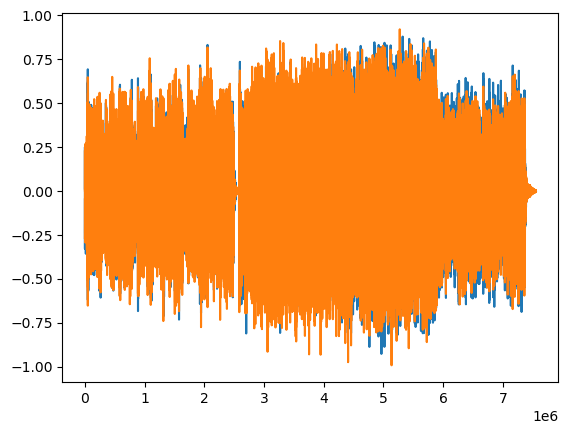

In [24]:
plt.plot(mus_train.tracks[0].audio)

Each data sample is a 4-second audio clip.  We split every audio track in the train folder and the first 30 tracks in the test folder into 4-second audio windows.  The windows that are less than 4 seconds at the end of each track are discarded.

In [25]:
# Count the number of samples (4-second window)
num_samples = 0

for i in range(len(train_name)):
    _, audio_mixture = wavfile.read("train/"+str(train_name[i])+"/linear_mixture.wav")
    _, vocals = wavfile.read("train/"+str(train_name[i])+"/vocals.wav")
    
    num_samples += len(audio_mixture) // window_len * 2
    
for i in range(30):
    _, audio_mixture = wavfile.read("test/"+str(test_name[i])+"/linear_mixture.wav")
    _, vocals = wavfile.read("test/"+str(test_name[i])+"/vocals.wav")

    num_samples += len(audio_mixture) // window_len * 2 

FileNotFoundError: [Errno 2] No such file or directory: 'train//linear_mixture.wav'

In [8]:
num_samples

60052

In [9]:
X_train = np.zeros((num_samples, window_len))
Y_train = np.zeros((num_samples, window_len))

In [10]:
# Construct samples using the tracks in "/train"
count = 0

for i in range(len(train_name)):
    _, audio_mixture = wavfile.read("train/"+str(train_name[i])+"/linear_mixture.wav")
    _, vocals = wavfile.read("train/"+str(train_name[i])+"/vocals.wav")
    
    num_frame = len(audio_mixture) // window_len
    
    for j in range(num_frame):
        # normalize the audio
        X_train[count, :] = audio_mixture[j*window_len:j*window_len+window_len, 0] / 2**num_bits # left channel
        X_train[count + 1, :] = audio_mixture[j*window_len:j*window_len+window_len, 1]  / 2**num_bits # right channel
        Y_train[count, :] = vocals[j*window_len:j*window_len+window_len, 0]  / 2**num_bits # left channel
        Y_train[count + 1, :] = vocals[j*window_len:j*window_len+window_len, 1]  / 2**num_bits # right channel
        count += 2
        
# We will use 30 out of 50 samples from the test folder as training samples
for i in range(30):
    _, audio_mixture = wavfile.read("test/"+str(test_name[i])+"/linear_mixture.wav")
    _, vocals = wavfile.read("test/"+str(test_name[i])+"/vocals.wav")

    num_frame = len(audio_mixture) // window_len

    for j in range(num_frame):
        # normalize the audio
        X_train[count, :] = audio_mixture[j*window_len:j*window_len+window_len, 0]  / 2**num_bits # left channel
        X_train[count + 1, :] = audio_mixture[j*window_len:j*window_len+window_len, 1]  / 2**num_bits # right channel
        Y_train[count, :] = vocals[j*window_len:j*window_len+window_len, 0]  / 2**num_bits # left channel
        Y_train[count + 1, :] = vocals[j*window_len:j*window_len+window_len, 1]  / 2**num_bits # right channel
        count += 2

In [11]:
X_train.shape

(60052, 44100)

Baseline model - it's a sequential model consisting of fully connected layers

In [12]:
baseline_model = tf.keras.Sequential([
    tf.keras.Input(shape=(44100,)),
    tf.keras.layers.Dense(30000, activation='relu'),
    tf.keras.layers.Dense(16800, activation='relu'),
    tf.keras.layers.Dense(30000, activation='relu'),
    tf.keras.layers.Dense(44100)
])

In [ ]:
# baseline_model = tf.keras.Sequential([
#     tf.keras.Input(shape=(176400,)),
#     tf.keras.layers.Dense(146200, activation='relu'),
#     tf.keras.layers.Dense(88200, activation='relu'),
#     tf.keras.layers.Dense(120000, activation='relu'),
#     tf.keras.layers.Dense(176400)
# ])

In [13]:
baseline_model.compile(optimizer="adam", loss="mae", metrics=["mae"])

In [14]:
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30000)          │ 1,323,030,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16800)          │   504,016,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30000)          │   504,030,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 44100)          │ 1,323,044,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,654,120,900 (13.61 GB)

 Trainable params: 3,654,120,900 (13.61 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
baseline_model.fit(X_train, Y_train, batch_size=64, epochs=10)

In [25]:
# fs

44100

In [32]:
# len(song1[:, 0]) / (44100*4)

42.811791383219955

In [16]:
# count = 0
# 
# for track in mus_train:
#     count += 1
#     print(track.name)
#     
# print(count)

A Classic Education - NightOwl
ANiMAL - Clinic A
ANiMAL - Easy Tiger
ANiMAL - Rockshow
Actions - Devil's Words
Actions - One Minute Smile
Actions - South Of The Water
Aimee Norwich - Child
Alexander Ross - Goodbye Bolero
Alexander Ross - Velvet Curtain
Angela Thomas Wade - Milk Cow Blues
Atlantis Bound - It Was My Fault For Waiting
Auctioneer - Our Future Faces
AvaLuna - Waterduct
BigTroubles - Phantom
Bill Chudziak - Children Of No-one
Black Bloc - If You Want Success
Celestial Shore - Die For Us
Chris Durban - Celebrate
Clara Berry And Wooldog - Air Traffic
Clara Berry And Wooldog - Stella
Clara Berry And Wooldog - Waltz For My Victims
Cnoc An Tursa - Bannockburn
Creepoid - OldTree
Dark Ride - Burning Bridges
Dreamers Of The Ghetto - Heavy Love
Drumtracks - Ghost Bitch
Faces On Film - Waiting For Ga
Fergessen - Back From The Start
Fergessen - Nos Palpitants
Fergessen - The Wind
Flags - 54
Giselle - Moss
Grants - PunchDrunk
Helado Negro - Mitad Del Mundo
Hezekiah Jones - Borrowed Hear